In [1]:
import os
from dataclasses import dataclass
from itertools import cycle

import numpy as np
import qutip as qt
import scqubits as scq
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from cycler import cycler

import floquet as ft
from floquet.model import CompositeModel   

In [ ]:
# ================== global variables - QUBIT C ==================


# num_states = 10
# qubit_params = {
#     'EJ': 3.6996,
#     'EC': 0.8394,
#     'EL': 1.0376,
#     'flux': 0.5,
#     'cutoff': 110,
# }
# fluxonium = scq.Fluxonium(**qubit_params, truncated_dim=num_states)
# N_osc    = 10              
# omega_osc = 7.327 * 2*np.pi   
# kappa_res = 2*np.pi * 0.0071   
# g         = 2 * np.pi * 0.042  
# # omega_d_fix  = 5.095 * 2*np.pi
# # omega_d_band = 2*np.pi * np.linspace(5.095 - 5e-3, 5.095 + 5e-3, 5) 
# flux_vals    = np.linspace(3.5, 4.4, 100)
# chi_ac_vals  = 2*np.pi * np.linspace(0, 0.2, 100) #n_max = 500Mhz/chi ==> 250-300 photon??
# omega_d_vals = 2*np.pi*np.linspace(3.5, 4.4, 100)


# ================== global variables - QUBIT A ==================


from pyparsing import Optional


num_states = 10
qubit_params = {
    'EJ': 4.167,
    'EC': 0.8308,
    'EL': 1.203,
    'flux': 0.5,
    'cutoff': 110

}
fluxonium = scq.Fluxonium(**qubit_params, truncated_dim=num_states)
N_osc    = 10              
omega_osc = 5.098 * 2*np.pi   
kappa_res = 2*np.pi * 0.005   
g         = 2 * np.pi * 0.026 
# omega_d_fix  = 5.095 * 2*np.pi
# omega_d_band = 2*np.pi * np.linspace(5.095 - 5e-3, 5.095 + 5e-3, 5) 
# flux_vals    = np.linspace(5, 6, 100) #FOR FLUX SWEEPS
chi_ac_vals  = 2*np.pi * np.linspace(0, 0.2, 100) #n_max = 500Mhz/chi ==> 250-300 photon??
omega_d_vals = 2*np.pi * np.linspace(5, 6, 100)
options = ft.Options(
    fit_range_fraction=0.6,
    fit_cutoff=3,
    overlap_cutoff=0.6,
    nsteps=30_000,
    num_cpus=3,
    save_floquet_modes=True,   # IMPORTANT: needed for branch expectations
)

# helper for qubit projection

def _columns_from_evecs(evecs, cutoff: int, num_states: int) -> np.ndarray:
    """Build a (cutoff, num_states) unitary matrix from eigenvectors."""
    if isinstance(evecs, (list, tuple)):
        M = np.column_stack([np.asarray(v).reshape(-1) for v in evecs])
    else:
        Mraw = np.asarray(evecs)
        cands = []
        for C in (Mraw, Mraw.T):
            if C.shape == (cutoff, num_states):
                err = np.linalg.norm(C.conj().T @ C - np.eye(num_states))
                cands.append((err, C))
        _, M = min(cands, key=lambda x: x[0])
    assert np.linalg.norm(M.conj().T @ M - np.eye(num_states)) < 1e-8, "U not unitary"
    return M

def bare_product_state(num_states: int, N_osc: int, q_idx: int, n: int) -> qt.Qobj:
    """|q_idx⟩ x |n⟩ as a Qobj."""
    return qt.tensor(qt.basis(num_states, q_idx), qt.basis(N_osc, n))


def closest_index(arr: np.ndarray, value: float) -> int:
    """find index of closest value in array."""
    return int(np.abs(np.asarray(arr) - value).argmin())

def extract_chi01_and_self_kerr(
    H_static: qt.Qobj,
    num_states: int,
    N_osc: int,
    max_photon_for_fit: int = 2,
) -> dict:
    """without scqubits"""
    evals, evecs = H_static.eigenstates()
    dim = len(evals)
    labels = [(q, n) for q in (0, 1) for n in range(max_photon_for_fit + 1)]
    bare_states = [bare_product_state(num_states, N_osc, q, n) for (q, n) in labels]

    overlaps = np.zeros((len(labels), dim), float)
    for li, psi_bare in enumerate(bare_states):
        for j, vec in enumerate(evecs):
            overlaps[li, j] = float(np.abs(psi_bare.overlap(vec))**2)

    label_to_index = {}
    remaining_labels = set(range(len(labels)))
    remaining_states = set(range(dim))
    overlaps_work = overlaps.copy()

    while remaining_labels:
        best_val, best_li, best_ej = -1.0, None, None
        for li in remaining_labels:
            for ej in remaining_states:
                if overlaps_work[li, ej] > best_val:
                    best_val = overlaps_work[li, ej]
                    best_li, best_ej = li, ej
        label_to_index[labels[best_li]] = best_ej
        remaining_labels.remove(best_li)
        remaining_states.remove(best_ej)
        overlaps_work[best_li, :] = -1.0
        overlaps_work[:, best_ej] = -1.0

    E = {lbl: float(evals[idx]) for lbl, idx in label_to_index.items()}

    omega_r_g_01 = E[(0, 1)] - E[(0, 0)]
    omega_r_g_12 = E[(0, 2)] - E[(0, 1)]
    omega_r_e_01 = E[(1, 1)] - E[(1, 0)]
    omega_r_e_12 = E[(1, 2)] - E[(1, 1)]
    omega_q_n0 = E[(1, 0)] - E[(0, 0)]
    omega_q_n1 = E[(1, 1)] - E[(0, 1)]
    omega_q_n2 = E[(1, 2)] - E[(0, 2)]

    return dict(
        chi_r=omega_r_e_01 - omega_r_g_01,
        chi_q_01=omega_q_n1 - omega_q_n0,
        chi_q_12=omega_q_n2 - omega_q_n1,
        K_g=omega_r_g_12 - omega_r_g_01,
        K_e=omega_r_e_12 - omega_r_e_01,
        omega_r_g=omega_r_g_01,
        omega_r_e=omega_r_e_01,
        omega_q_n0=omega_q_n0,
        omega_q_n1=omega_q_n1,
        omega_q_n2=omega_q_n2,
        E=E,
    )

def build_static_composite(
    flux: float,
    qubit_params: dict,
    num_states: int,
    N_osc: int,
    omega_osc: float,
    g: float,
    coupling_op: str = "charge",
):

    qparams = {**qubit_params, "flux": float(flux)}
    q = scq.Fluxonium(**qparams, truncated_dim=num_states)
    scq.HilbertSpace([q]).generate_lookup()

    evals_q, evecs = q.eigensys(evals_count=num_states)  
    H0_flux = 2*np.pi * qt.Qobj(
        np.diag(evals_q - evals_q[0]),
        dims=[[num_states], [num_states]],
    )
    q_op = q.n_operator() if coupling_op == "charge" else q.phi_operator()
    op_arr = np.array(q_op)
    cutoff = op_arr.shape[0]
    Uq = _columns_from_evecs(evecs, cutoff, num_states)
    op_proj = Uq.conj().T @ op_arr @ Uq
    H1_flux = qt.Qobj(op_proj, dims=[[num_states], [num_states]])
    H1_flux = 0.5 * (H1_flux + H1_flux.dag())
    a = qt.destroy(N_osc)
    Iq, Ir = qt.qeye(num_states), qt.qeye(N_osc)
    H_static = (qt.tensor(H0_flux, Ir) + 
                omega_osc * qt.tensor(Iq, a.dag()*a) + 
                g * qt.tensor(H1_flux, (a + a.dag())))
    return H_static, H0_flux, H1_flux, q, np.asarray(evals_q, float), a

def flux_sweep_chi_kerr(
    flux_vals: np.ndarray,
    qubit_params: dict,
    num_states: int,
    N_osc: int,
    omega_osc: float,
    g: float,
    coupling_op: str = "charge",
) -> dict:
    """sweep flux and extract chi/Kerr at each point."""
    flux_vals = np.asarray(flux_vals, float)
    n_flux = len(flux_vals)

    results = {k: np.zeros(n_flux) for k in 
               ['chi_r', 'chi_q_01', 'K_g', 'K_e', 'omega_r_g', 'omega_r_e']}

    for i, flux in enumerate(flux_vals):
        H_static, *_ = build_static_composite(
            flux, qubit_params, num_states, N_osc, omega_osc, g, coupling_op
        )
        kerr_info = extract_chi01_and_self_kerr(H_static, num_states, N_osc)
        for k in results:
            results[k][i] = kerr_info[k]

    results['flux_vals'] = flux_vals
    return results

@dataclass
class CompositeParams:
    """config for composite Floquet analysis. note: units are rad/s."""
    qubit_params: dict
    num_states: int
    N_osc: int
    omega_osc: float    
    g: float              #
    kappa_res: float      
    options: ft.Options
    drive_on: str = "qubit"           
    coupling_op: str = "charge"       
    amp_mapping: str = "composite"

class CompositeFloquetRunner:
    """
    composite Floquet analysis
    amp_mapping options:
      - "composite": chi2amp on composite H0, H1
      - "resonator_linear": lin. Lorentzian (no kerr)
      - "resonator_kerr": with kerr correction to lorentzian
    """
    def __init__(self, cfg: CompositeParams, results_dir: Optional[str] = None):
        self.cfg = cfg
        self.results_dir = results_dir
        if results_dir:
            os.makedirs(results_dir, exist_ok=True)

    def build_static(self, flux: float):
        p = self.cfg
        H_static, H0_flux, H1_flux, q, evals_q, a = build_static_composite(
            flux, p.qubit_params, p.num_states, p.N_osc, 
            p.omega_osc, p.g, p.coupling_op
        )
        Iq, Ir = qt.qeye(p.num_states), qt.qeye(p.N_osc)
        if p.drive_on == "qubit":
            H1_drive = qt.tensor(H1_flux, Ir)
        elif p.drive_on == "resonator":
            H1_drive = qt.tensor(Iq, (a + a.dag()))
        return H_static, H1_drive, H0_flux, H1_flux, q, evals_q

    def _chi_to_amp_resonator_linear(self, chi_ac_vals, omega_d_vals,
                                     chi_per_photon, omega_r, kappa):
        """Linear chi 2 amplitude. based on transfer function of driven resonator"""
        chi_grid = chi_ac_vals[:, None]
        n_target = chi_grid / np.abs(chi_per_photon)
        Delta = omega_d_vals[None, :] - omega_r
        return np.sqrt(n_target * (Delta**2 + (kappa/2)**2))

    def _chi_to_amp_resonator_kerr(self, chi_ac_vals, omega_d_vals,
                                   chi_per_photon, omega_r, K, kappa):
        """with Kerr chi 2 amplitude mapping"""
        chi_grid = chi_ac_vals[:, None]
        n_target = chi_grid / np.abs(chi_per_photon)
        Delta = omega_d_vals[None, :] - omega_r
        return np.sqrt(n_target * ((kappa/2)**2 + (Delta + K*n_target)**2))

    def build_model(self, flux: float, omega_d_vals: np.ndarray, chi_ac_vals: np.ndarray):
        """construct CompositeModel with chi2amp of choiced"""
        p = self.cfg
        omega_d_vals = np.asarray(omega_d_vals, float)
        chi_ac_vals = np.asarray(chi_ac_vals, float)
        Nchi, Nw = len(chi_ac_vals), len(omega_d_vals)
        H_static, H1_drive, H0_flux, H1_flux, q, evals_q = self.build_static(flux)
        kerr_info = extract_chi01_and_self_kerr(H_static, p.num_states, p.N_osc)
        model = CompositeModel(
            H0_bare=H_static,
            H1_drive=H1_drive,
            omega_d_values=omega_d_vals,
            drive_amplitudes=np.zeros((Nchi, Nw)),
            subsystem_dims=(p.num_states, p.N_osc),
            state_labels_dims=(p.num_states, p.N_osc),
        )
        dressed_indices = model.labels_to_indices([(0, 0), (1, 0)])
        if p.amp_mapping == "composite":
            chi2amp = ft.ChiacToAmp(
                H0=model.H0, H1=model.H1,
                state_indices=dressed_indices,
                omega_d_values=omega_d_vals,
            )
            drive_amps = chi2amp.amplitudes_for_omega_d(chi_ac_vals)
        else:
            if p.drive_on != "resonator":
                raise ValueError("kerr correction/lorentzian response mapping requires drive_on='resonator'")
            chi_per_photon = kerr_info["chi_q_01"]
            omega_r = kerr_info["omega_r_g"]
            K = kerr_info["K_g"]
            if p.amp_mapping == "resonator_linear":
                drive_amps = self._chi_to_amp_resonator_linear(
                    chi_ac_vals, omega_d_vals, chi_per_photon, omega_r, p.kappa_res
                )
            elif p.amp_mapping == "resonator_kerr":
                drive_amps = self._chi_to_amp_resonator_kerr(
                    chi_ac_vals, omega_d_vals, chi_per_photon, omega_r, K, p.kappa_res
                )
        model.drive_amplitudes = drive_amps
        return model, dressed_indices, (q, evals_q, kerr_info)




def run_drive_sweep(self, flux: float, omega_d_vals: np.ndarray,
                    chi_ac_vals: np.ndarray, save_path: Optional[str] = None):
    """Floquet analysis for drive sweep at fixed flux."""
    p = self.cfg
    model, dressed_indices, (q, evals_q, kerr_info) = self.build_model(
        flux, omega_d_vals, chi_ac_vals
    )
    fa = ft.FloquetAnalysis(model, state_indices=dressed_indices, options=p.options)
    data = fa.run(filepath=save_path)
    data["_metadata"] = {
        "flux_point": float(flux),
        "omega_d_values": np.asarray(omega_d_vals, float),
        "chi_ac_vals": np.asarray(chi_ac_vals, float),
        "drive_on": p.drive_on,
        "coupling_op": p.coupling_op,
        "amp_mapping": p.amp_mapping,
        "dressed_indices": dressed_indices,
        "subsystem_dims": (p.num_states, p.N_osc),
        "qubit_params": p.qubit_params,
        "omega_osc": p.omega_osc,
        "g": p.g,
        "kappa_res": p.kappa_res,
        "evals_q": np.asarray(evals_q, float),
        "static_chi_and_kerr": kerr_info,
    }
    return data, model

def run_flux_sweep(self, flux_vals: np.ndarray, omega_d_vals: np.ndarray,
                    chi_ac_vals: np.ndarray):
    """Run drive sweep at each flux point."""
    return [(flux, *self.run_drive_sweep(flux, omega_d_vals, chi_ac_vals))
            for flux in np.asarray(flux_vals, float)]

#post sweeps
def add_composite_expectations(results: dict, model, Nq: int, Nosc: int) -> dict:
    """avg exc, avg resonator photon num for each Floquet branch."""
    if "floquet_modes" not in results:
        raise ValueError("save_floquet_modes=True must be set in Options")
    modes = np.asarray(results["floquet_modes"]) 
    Nw, Na, Ns, dim = modes.shape
    assert dim == Nq * Nosc
    U = model.U.full()
    modes_flat = modes.reshape(-1, dim)
    probs = np.abs(modes_flat @ U.T)**2
    nq_indices = np.repeat(np.arange(Nq), Nosc)
    nr_indices = np.tile(np.arange(Nosc), Nq)
    results["avg_qubit_excitation"] = (probs @ nq_indices).reshape(Nw, Na, Ns)
    results["avg_resonator_photons"] = (probs @ nr_indices).reshape(Nw, Na, Ns)
    return results

def build_index_label_map(model, Nq: int, Nosc: int, 
                          overlap_cutoff: float = 0.5):
    """map Floquet branch index --> {nq, nr} label based on overlap."""
    U = model.U
    index_info = {}

    for nq in range(Nq):
        for nr in range(Nosc):
            bare_ket = qt.tensor(qt.basis(Nq, nq), qt.basis(Nosc, nr))
            coeffs = (U.dag() * bare_ket).full().ravel()
            idx = int(np.argmax(np.abs(coeffs)))
            max_ovlp = float(np.max(np.abs(coeffs)))
            if idx not in index_info or max_ovlp > index_info[idx][2]:
                index_info[idx] = (nq, nr, max_ovlp)

    return {idx: f"({nq},{nr})" if ovlp >= overlap_cutoff else f"{idx} (??)"
            for idx, (nq, nr, ovlp) in index_info.items()}

def slice_omega(results: dict, omega_idx: int) -> dict:
    """results at a single drive frequency index."""
    meta = results["_metadata"]
    omega_d_vals = np.asarray(meta["omega_d_values"])
    chi_ac_vals = np.asarray(meta["chi_ac_vals"])

    out = {}
    for k, v in results.items():
        if k == "_metadata":
            continue
        arr = np.asarray(v)
        if arr.ndim == 3 and arr.shape[0] == len(omega_d_vals):
            out[k] = arr[omega_idx:omega_idx+1, :, :]
        else:
            out[k] = v

    out["_metadata"] = {
        **{k: meta.get(k) for k in ["flux_point", "qubit_name"]},
        "omega_d": float(omega_d_vals[omega_idx]),
        "chi_grid": chi_ac_vals,
    }
    return out

In [ ]:
#plotting

from typing import Any, Dict, List, Optional, Sequence, Tuple, Union


def plot_chi_kerr_vs_flux(chi_kerr_data: dict):
    """plot chi and self kerr vs flux."""
    flux = chi_kerr_data["flux_vals"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax = axes[0]
    ax.plot(flux, chi_kerr_data["chi_r"]/(2*np.pi), label=r"$\chi_{01}$ (resonator)")
    ax.plot(flux, chi_kerr_data["chi_q_01"]/(2*np.pi), label=r"$\chi_{01}$ (qubit)")
    ax.set_xlabel(r"Flux ($\Phi/\Phi_0$)")
    ax.set_ylabel("Dispersive shift [GHz]")
    ax.legend()
    ax.set_title("Dispersive shifts vs flux")
    ax = axes[1]
    ax.plot(flux, chi_kerr_data["K_g"]/(2*np.pi)*1e3, label=r"$K_g$")
    ax.plot(flux, chi_kerr_data["K_e"]/(2*np.pi)*1e3, label=r"$K_e$")
    ax.set_xlabel(r"Flux ($\Phi/\Phi_0$)")
    ax.set_ylabel("Self-Kerr [MHz]")
    ax.legend()
    ax.set_title("Self-Kerr vs flux")
    plt.tight_layout()
    plt.show()

def plot_scar_map(
    results: dict,
    *,
    state_index: int = 0,
    target_GHz: Optional[float] = None,
    clip_max: float = 0.5,
    mask_nr_max: Optional[float] = None,
    mask_nq_max: Optional[float] = None,
    title: str = "",
    cmap: str = "Blues",
    figsize: Tuple[float, float] = (8, 5),
):
    meta = results["_metadata"]
    omega_d_vals = np.asarray(meta["omega_d_values"])
    chi_ac_vals = np.asarray(meta["chi_ac_vals"])
    scar = 1.0 - np.abs(results["displaced_state_overlaps"][:, :, state_index])**2
    if mask_nr_max is not None or mask_nq_max is not None:
        avg_nr = np.asarray(results["avg_resonator_photons"])[:, :, state_index]
        avg_nq = np.asarray(results["avg_qubit_excitation"])[:, :, state_index]
        keep = np.ones_like(scar, dtype=bool)
        if mask_nr_max is not None:
            keep &= (avg_nr < mask_nr_max)
        if mask_nq_max is not None:
            keep &= (avg_nq < mask_nq_max)
        scar = np.where(keep, scar, np.nan)
    fig, ax = plt.subplots(figsize=figsize)
    extent = [omega_d_vals.min()/(2*np.pi), omega_d_vals.max()/(2*np.pi),
              chi_ac_vals.min()/(2*np.pi), chi_ac_vals.max()/(2*np.pi)]
    im = ax.imshow(scar.T, origin="lower", aspect="auto", extent=extent,
                   cmap=cmap, vmin=0, vmax=clip_max)

    #mark a target frequency
    if target_GHz is not None:
        omega_idx = closest_index(omega_d_vals/(2*np.pi), target_GHz)
        ax.axvline(omega_d_vals[omega_idx]/(2*np.pi), color="crimson", ls="--", lw=1.5, alpha=0.8)
    ax.set_xlabel(r"$\omega_d/2\pi$ [GHz]")
    ax.set_ylabel(r"$\chi_{\rm ac}/2\pi$ [GHz]")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label=r"$1-|\langle\psi_{\rm disp}|\Phi\rangle|^2$")
    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_kerr_branches(
    results: dict,
    model,
    target_GHz: float,
    branch_indices: Tuple[int, int] = (0, 1),
    figsize: Tuple[float, float] = (6.5, 4),
):
    """<avg photon num>, effective qubit drive, and eff. resonator freq vs chi ac at fixed drive frq"""
    meta = results["_metadata"]
    kinfo = meta["static_chi_and_kerr"]
    omega_d_vals = np.asarray(meta["omega_d_values"])
    chi_ac_vals = np.asarray(meta["chi_ac_vals"])
    chi_GHz = chi_ac_vals / (2*np.pi)

    omega_idx = closest_index(omega_d_vals/(2*np.pi), target_GHz)
    omega_d_GHz = omega_d_vals[omega_idx] / (2*np.pi)

    n_r = np.asarray(results["avg_resonator_photons"])
    idx_g, idx_e = branch_indices
    n_g, n_e = n_r[omega_idx, :, idx_g], n_r[omega_idx, :, idx_e]

    g = meta["g"]
    A_eff_g = 2 * g * np.sqrt(n_g) / (2*np.pi)
    A_eff_e = 2 * g * np.sqrt(n_e) / (2*np.pi)

    omega_eff_g = kinfo["omega_r_g"] + kinfo["K_g"] * n_g
    omega_eff_e = kinfo["omega_r_e"] + kinfo["K_e"] * n_e

    #avg resonator num and effective drive
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(chi_GHz, n_g, "C0-", label=r"$\langle n_r\rangle$ branch 0")
    ax.plot(chi_GHz, n_e, "C1-", label=r"$\langle n_r\rangle$ branch 1")
    ax.set_xlabel(r"$\chi_{\rm ac}/2\pi$ [GHz]")
    ax.set_ylabel(r"$\langle n_r\rangle$")
    ax.grid(alpha=0.3, ls="--", lw=0.5)
    ax2 = ax.twinx()
    ax2.plot(chi_GHz, A_eff_g, "C0--", lw=1.5, label=r"$2g\sqrt{n_r}$ (0)")
    ax2.plot(chi_GHz, A_eff_e, "C1--", lw=1.5, label=r"$2g\sqrt{n_r}$ (1)")
    ax2.set_ylabel(r"Effective qubit drive $2g\sqrt{n_r}/2\pi$ [GHz]")
    ax.set_title(rf"self kerr analysis at $\omega_d/2\pi \approx {omega_d_GHz:.3f}$ GHz")
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=9, loc="upper left")
    plt.tight_layout()
    plt.show()

    #eff resonator freq
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(chi_GHz, omega_eff_g/(2*np.pi), label=r"$\omega_{r,\mathrm{eff}}^{(g)}$")
    ax.plot(chi_GHz, omega_eff_e/(2*np.pi), label=r"$\omega_{r,\mathrm{eff}}^{(e)}$")
    ax.axhline(omega_d_GHz, color="0.4", ls=":", label=r"$\omega_d$")
    ax.set_xlabel(r"$\chi_{\rm ac}/2\pi$ [GHz]")
    ax.set_ylabel(r"$\omega_{r,\mathrm{eff}}/2\pi$ [GHz]")
    ax.grid(alpha=0.3, ls="--", lw=0.5)
    ax.legend()
    ax.set_title("Effective resonator frequency (Floquet + static Kerr)")
    plt.tight_layout()
    plt.show()

    return omega_idx

In [ ]:
def plot_branch_analysis_at_drive(
    results: dict,
    *,
    omega_idx: Optional[int] = None,
    target_GHz: Optional[float] = None,
    max_curves: Optional[int] = None,
    highlight_states: Optional[Sequence[int]] = None,
    plot_quantity: str = "avg_qubit_excitation",
    gray_others: bool = True,
    qubit_name: Optional[str] = None,
    state_label_map: Optional[Dict[int, str]] = None,
    figsize: Tuple[float, float] = (7, 4),
):
    """branch analysis at fixed drive frequency"""


    meta = results["_metadata"]
    omega_d_vals = np.asarray(meta["omega_d_values"])
    chi_ac_vals = np.asarray(meta["chi_ac_vals"])

    if omega_idx is None:
        if target_GHz is None:
            raise ValueError("need either omega_idx or target_GHz")
        omega_idx = closest_index(omega_d_vals/(2*np.pi), target_GHz)
    data = np.asarray(results[plot_quantity])[omega_idx] 
    Nchi, Nstates = data.shape
    chi_GHz = chi_ac_vals / (2*np.pi)

    plot_indices = np.arange(min(max_curves or Nstates, Nstates))
    hi = set(highlight_states or [])
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    fig, ax = plt.subplots(figsize=figsize)
    def label_for(j):
        return state_label_map.get(j, str(j)) if state_label_map else str(j)

    for j in plot_indices:
        y = data[:, j]
        if gray_others and j not in hi:
            ax.plot(chi_GHz, y, color='0.75', alpha=0.4, lw=1.0)
        else:
            lw = 2.0 if j in hi else 1.0
            label = label_for(j) + (" *" if j in hi else "")
            ax.plot(chi_GHz, y, lw=lw, label=label, color=colors[j % 10])

    
    ylabel_map = {
        'avg_qubit_excitation': r"$\langle n_q \rangle$",
        'avg_resonator_photons': r"$\langle n_r \rangle$",
        'displaced_state_overlaps': r"$|\langle \mathrm{disp}|\mathrm{Floquet}\rangle|^2$",
    }
    ax.set_ylabel(ylabel_map.get(plot_quantity, plot_quantity))
    ax.set_xlabel(r"$\chi_{\rm ac}/2\pi$ [GHz]")

    title_parts = []
    if qubit_name:
        title_parts.append(f"q{qubit_name}")
    if meta.get("flux_point"):
        title_parts.append(f"flux={meta['flux_point']:.4f}")
    title_parts.append(rf"$\omega_d/2\pi$={omega_d_vals[omega_idx]/(2*np.pi):.3f} GHz")
    ax.set_title(", ".join(title_parts))

    ax.grid(alpha=0.3, ls="--", lw=0.5)
    ax.legend(fontsize=9, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    return fig, ax

In [ ]:
options = ft.Options(
    fit_range_fraction=0.6,
    fit_cutoff=3,
    overlap_cutoff=0.8,
    nsteps=30_000,
    num_cpus=3,
    save_floquet_modes=True,   # IMPORTANT: needed for branch expectations
)
chi_ac_vals  = 2*np.pi * np.linspace(0, 0.2, 200) #n_max = 500Mhz/chi ==> 250-300 photon??
omega_d_vals = 2*np.pi * np.linspace(5, 6, 200)

params = CompositeParams(
    qubit_params=qubit_params,
    num_states=num_states,
    N_osc=N_osc,
    omega_osc=omega_osc,
    g=g,
    kappa_res=kappa_res,
    options=options,
    drive_on="qubit",
    coupling_op="charge",
    use_composite_chi=True,
)
flux_point = 0.5
runner = CompositeFloquetRunner(params)
save_path = "comp_flux_{:.4f}_drive.npz".format(flux_point)

results_comp, model_comp = runner.run_drive_sweep(
    flux=flux_point,
    omega_d_vals=omega_d_vals,
    chi_ac_vals=chi_ac_vals,
    save_path=save_path,    
)

results_comp = add_composite_expectations(
    results_comp, model_comp,
    Nq=num_states,
    Nosc=N_osc,
)


Running floquet simulation with parameters: 
model: H0_bare: Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dia, isherm=True
Qobj data =
[[  0.        +0.j   0.        +0.j   0.        +0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 [  0.        +0.j  32.0316787 +0.j   0.        +0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j  64.06335739+0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 ...
 [  0.        +0.j   0.        +0.j   0.        +0.j ... 384.75788501+0.j
    0.        +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j ...   0.        +0.j
  416.7895637 +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j ...   0.        +0.j
    0.        +0.j 448.8212424 +0.j]]
H1_drive: Quantum object: dims=[[10, 10], [10, 10]], shape=(100, 100), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.

 C:\Users\slab\AppData\Local\Temp\ipykernel_22692\1878905587.py: 334

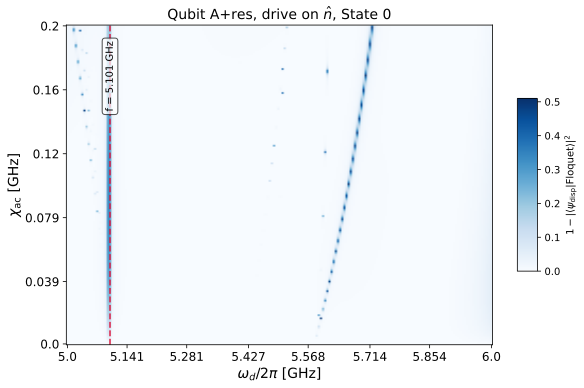

In [ ]:
plot_data =  (1.0 - np.abs(results_comp["displaced_state_overlaps"][:, :, 0])**2).T
omega_idx = mark_plot_drive_scar_map(
    plot_data,
    results_comp["_metadata"]["omega_d_values"],
    results_comp["_metadata"]["chi_ac_vals"],
    target_GHz=  5.098,
    q_name="A+res",
    operator=r"$\hat{n}$",
    state=0,
)

In [124]:
np.min(np.abs(results_comp["displaced_state_overlaps"][:, :, 1])**2)

np.float64(0.4774301819088271)

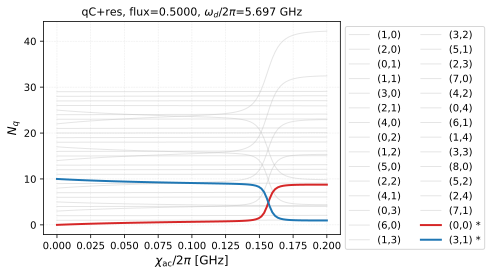

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'qC+res, flux=0.5000, $\\omega_d/2\\pi$=5.697 GHz'}, xlabel='$\\chi_{\\rm ac}/2\\pi$ [GHz]', ylabel='$N_{q}$'>)

In [ ]:
omega_idx = closest_index(
    results_comp["_metadata"]["omega_d_values"]/(2*np.pi),
    5.7
)

highlight_labels = [(0,0), (3,1)]
highlight_states = model_comp.labels_to_indices(highlight_labels)
state_label_map  = build_index_label_map(model_comp, Nq=num_states, Nosc=N_osc)

prop_cycler = cycler(color=["tab:red", "tab:blue", "tab:green","tab:orange", "tab:purple"])  # one per highlighted branch

plot_branch_analysis_at_drive(
    results_comp,
    results_comp["_metadata"]["omega_d_values"],
    results_comp["_metadata"]["chi_ac_vals"],
    omega_idx=omega_idx,
    max_curves=30,
    highlight_states=highlight_states,
    plot_quantity="avg_excitation",
    gray_others=True,
    qubit_name="C+res",
    state_label_map=state_label_map,
    prop_cycler=prop_cycler,
)


In [ ]:
params = CompositeParams(
    qubit_params=qubit_params,
    num_states=num_states,
    N_osc=N_osc,
    omega_osc=omega_osc,
    g=g,
    kappa_res=kappa_res,
    options=options,
    drive_on="resonator",      # or "qubit"
    coupling_op="charge",
    use_composite_chi=True,    )
options = ft.Options(
    fit_range_fraction=0.6,
    fit_cutoff=3,
    overlap_cutoff=0.6,
    nsteps=30_000,
    num_cpus=3,
    save_floquet_modes=True, 
)
flux_point = 0.4
runner = CompositeFloquetRunner(params)
results_comp, model_comp = runner.run_drive_sweep(
    flux=flux_point,
    omega_d_vals=omega_d_vals,
    chi_ac_vals=chi_ac_vals,
    save_path="comp_flux_{:.4f}_drive.npz".format(flux_point),
)


NameError: name 'a' is not defined

### 

### Build the Composite Class with self-kerr effects included

In [ ]:
chi_ac_vals  = 2*np.pi * np.linspace(0, 0.2, 200)     # [rad/s]
omega_d_vals = 2*np.pi * np.linspace(5.0, 6.0, 200)   # [rad/s]

options = ft.Options(
    fit_range_fraction=0.6,
    fit_cutoff=3,
    overlap_cutoff=0.8,
    nsteps=30_000,
    num_cpus=3,
    save_floquet_modes=True,
)

params_q = CompositeParams(
    qubit_params=qC_params,
    num_states=dim_fluxonium,
    N_osc=N_osc,
    omega_osc=omega_osc,
    g=g,
    kappa_res=kappa_res,
    options=options,
    drive_on="qubit",
    coupling_op="charge",
)

flux_point = 0.5
runner_q = CompositeFloquetRunner(params_q)

results_q, model_q = runner_q.run_drive_sweep(
    flux=flux_point,
    omega_d_vals=omega_d_vals,
    chi_ac_vals=chi_ac_vals,
    save_path=f"qdrive_flux_{flux_point:.4f}.npz",
)

results_q = add_composite_expectations(results_q, model_q,
                                       Nq=num_states, Nosc=N_osc)

# Kerr‑aware branch plots at ω_d ≈ ω_osc
kerr_branch_plots(results_q, model_q, target_GHz=5.098,
                  branch_indices=(0, 1))


Running floquet simulation with parameters: 
model: H0_bare: Quantum object: dims=[[15, 10], [15, 10]], shape=(150, 150), type='oper', dtype=Dia, isherm=True
Qobj data =
[[  0.        +0.j   0.        +0.j   0.        +0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 [  0.        +0.j  46.03689875+0.j   0.        +0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j  92.07379749+0.j ...   0.        +0.j
    0.        +0.j   0.        +0.j]
 ...
 [  0.        +0.j   0.        +0.j   0.        +0.j ... 548.80256129+0.j
    0.        +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j ...   0.        +0.j
  594.83946004+0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j ...   0.        +0.j
    0.        +0.j 640.87635878+0.j]]
H1_drive: Quantum object: dims=[[15, 10], [15, 10]], shape=(150, 150), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.